In [29]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [30]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def flow_step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)
    
    
"""Flow is actually vector field u
"""

'Flow is actually vector field u\n'

# Training

In [31]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 2e-4)
loss_fn = nn.MSELoss()

loss_history = []


for i in range(100000):
    x_1 = Tensor(make_moons(1024, noise=0.0)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    
    
    optimizer.zero_grad()
    pred = flow(t=t, x_t=x_t)
    loss = loss_fn(pred, dx_t)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

    if i % 500 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")
        
# Save model
torch.save(flow.state_dict(), "flow_model.pt")  ## only model parameters
print("Model saved to 'flow_model.pt' ")
        


Step 0, Loss: 1.7309
Step 500, Loss: 1.0243
Step 1000, Loss: 1.0625
Step 1500, Loss: 1.0594
Step 2000, Loss: 0.9979
Step 2500, Loss: 1.0684
Step 3000, Loss: 1.0045
Step 3500, Loss: 0.9968
Step 4000, Loss: 1.0542
Step 4500, Loss: 1.0164
Step 5000, Loss: 1.0447
Step 5500, Loss: 0.9500
Step 6000, Loss: 0.9822
Step 6500, Loss: 1.0224
Step 7000, Loss: 0.9991
Step 7500, Loss: 1.0364
Step 8000, Loss: 0.9371
Step 8500, Loss: 0.9699
Step 9000, Loss: 0.9655
Step 9500, Loss: 0.9825
Step 10000, Loss: 0.9827
Step 10500, Loss: 0.9998
Step 11000, Loss: 0.9646
Step 11500, Loss: 0.9659
Step 12000, Loss: 0.9796
Step 12500, Loss: 1.0427
Step 13000, Loss: 1.0065
Step 13500, Loss: 0.9808
Step 14000, Loss: 0.9861
Step 14500, Loss: 0.9388
Step 15000, Loss: 0.9578
Step 15500, Loss: 0.9642
Step 16000, Loss: 0.9353
Step 16500, Loss: 0.9331
Step 17000, Loss: 0.9925
Step 17500, Loss: 0.9429
Step 18000, Loss: 0.9037
Step 18500, Loss: 0.9787
Step 19000, Loss: 0.9045
Step 19500, Loss: 0.9408
Step 20000, Loss: 0.9661

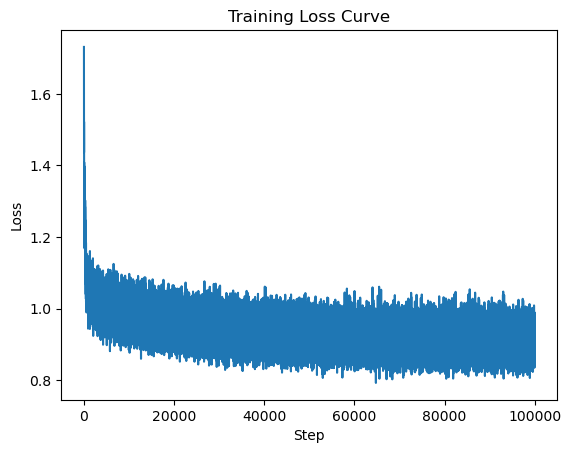

In [32]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [33]:
for name, param in flow.named_parameters():
    if param.requires_grad:
        print(f"{name:30} | shape: {str(tuple(param.shape)):15} | params: {param.numel()}")

net.0.weight                   | shape: (64, 3)         | params: 192
net.0.bias                     | shape: (64,)           | params: 64
net.2.weight                   | shape: (64, 64)        | params: 4096
net.2.bias                     | shape: (64,)           | params: 64
net.4.weight                   | shape: (64, 64)        | params: 4096
net.4.bias                     | shape: (64,)           | params: 64
net.6.weight                   | shape: (2, 64)         | params: 128
net.6.bias                     | shape: (2,)            | params: 2


# Sampling

/tmp/ipykernel_527790/2665395731.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load("flow_model.pt"))


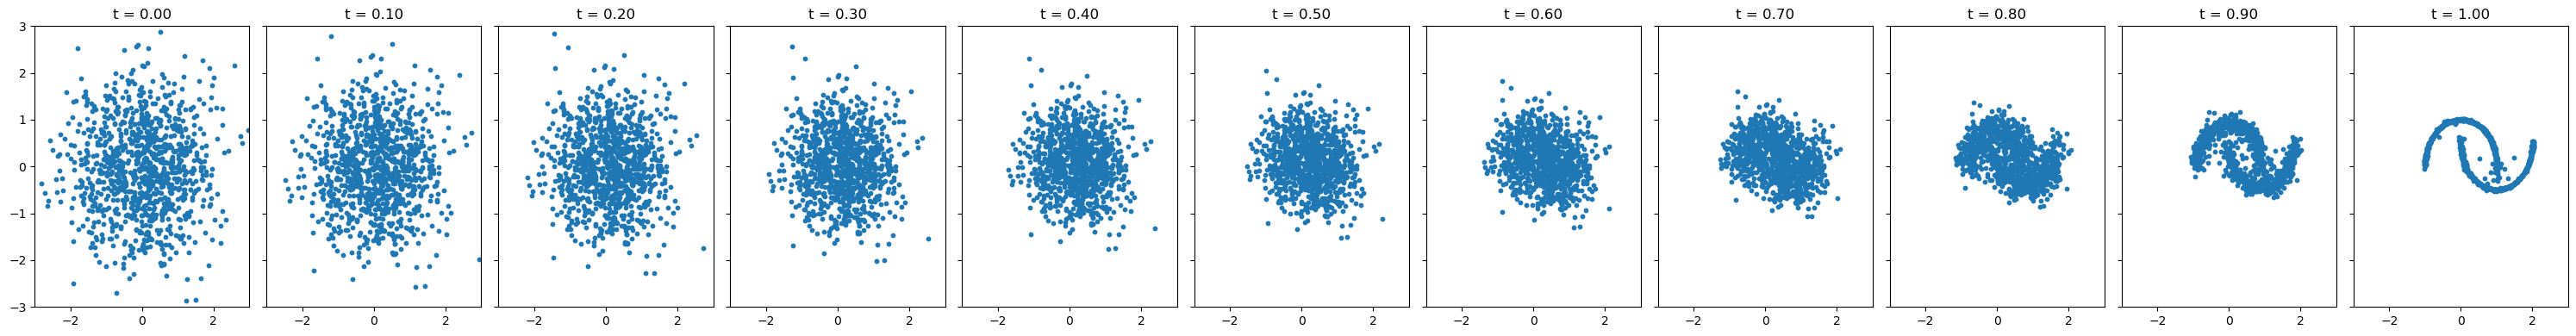

In [34]:
flow = Flow()
flow.load_state_dict(torch.load("flow_model.pt"))
flow.eval()

x = torch.randn(1000, 2)
n_steps = 10
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.flow_step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()